In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

import anndata as ad
import scanpy as sc

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from umap import UMAP

from scroutines import powerplots
import time

import importlib
importlib.reload(powerplots)
from scroutines import basicu
from scroutines.miscu import is_in_polygon

import utils_merfish

In [2]:
np.random.seed(0)

In [3]:
def binning_pipe(adata, n=20, layer='lnorm', bin_type='depth_bin'):
    """
    """
    assert bin_type in ['depth_bin', 'width_bin']
    # bin it 
    depth_bins, depth_binned = utils_merfish.binning(adata.obs['depth'].values, n)
    width_bins, width_binned = utils_merfish.binning(adata.obs['width'].values, n)

    norm_ = pd.DataFrame(adata.layers[layer], columns=adata.var.index)
    norm_['depth_bin'] = depth_binned
    norm_['width_bin'] = width_binned
    
    norm_mean = norm_.groupby(bin_type).mean(numeric_only=True)
    norm_sem  = norm_.groupby(bin_type).sem(numeric_only=True)
    norm_std  = norm_.groupby(bin_type).std(numeric_only=True)
    norm_n    = norm_[bin_type].value_counts(sort=False)

    return norm_mean, norm_sem, norm_std, norm_n, depth_binned, width_binned, depth_bins, width_bins



In [4]:
from merfish_datasets import merfish_datasets
from utils_merfish import rot2d
import json

directories = merfish_datasets
print(merfish_datasets)




{'P14NR_ant': 'merfish_06142023/ant/region0', 'P28NR_ant': 'merfish_06142023/ant/region1', 'P14NR_pos': 'merfish_06142023/pos/region0', 'P28NR_pos': 'merfish_06142023/pos/region1', 'P21NR_ant': 'merfish_20231114/region0', 'P21DR_ant': 'merfish_20231114/region2', 'P28DR_ant': 'merfish_20231114/region1', 'P21NR_pos': 'merfish_20231120/region0', 'P21DR_pos': 'merfish_20231120/region1', 'P28DR_pos': 'merfish_20231120/region2'}


In [5]:
names = ['P28NR_pos', 'P28NR_ant', 'P28DR_ant',]
dfs = {}
adatas = {}
for name in names:
    dirc = directories[name]
    f_spot = f'/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/merfish/{dirc}/detected_transcripts_v1l23.csv'
    f_main = f'/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/merfish/organized/{name}_ctxglut_240411.h5ad'
    df = pd.read_csv(f_spot) # , nrows=1000)
    adata = ad.read_h5ad(f_main)
    
    
    dfs[name] = df
    adatas[name] = adata
    print(name, len(df), len(adata))

P28NR_pos 2194701 25253
P28NR_ant 1050088 20466
P28DR_ant 2172472 10678


In [6]:
area_factors = {}
for i, name in enumerate(names):
    adata = adatas[name]
    bound_l, bound_r, bound_d = adata.uns['bound_lrd']
    area = np.abs(bound_r - bound_l)*bound_d
    if i == 0:
        area0 = area
        
    area_factors[name] = area/area0
        
    print(name, bound_l, bound_r, bound_d, area/area0)
    


P28NR_pos 1400 3400 400 1.0
P28NR_ant 3000 4200 400 0.6
P28DR_ant 2500 4600 400 1.05


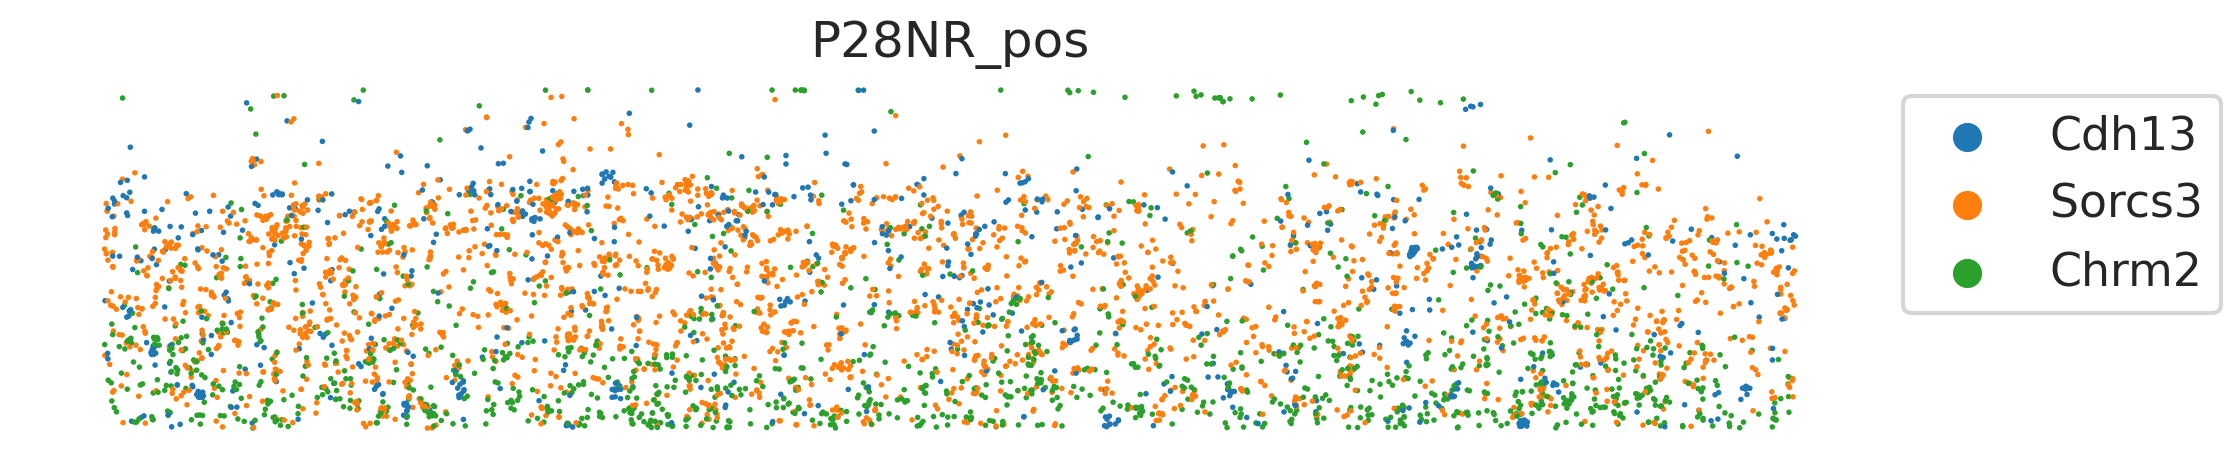

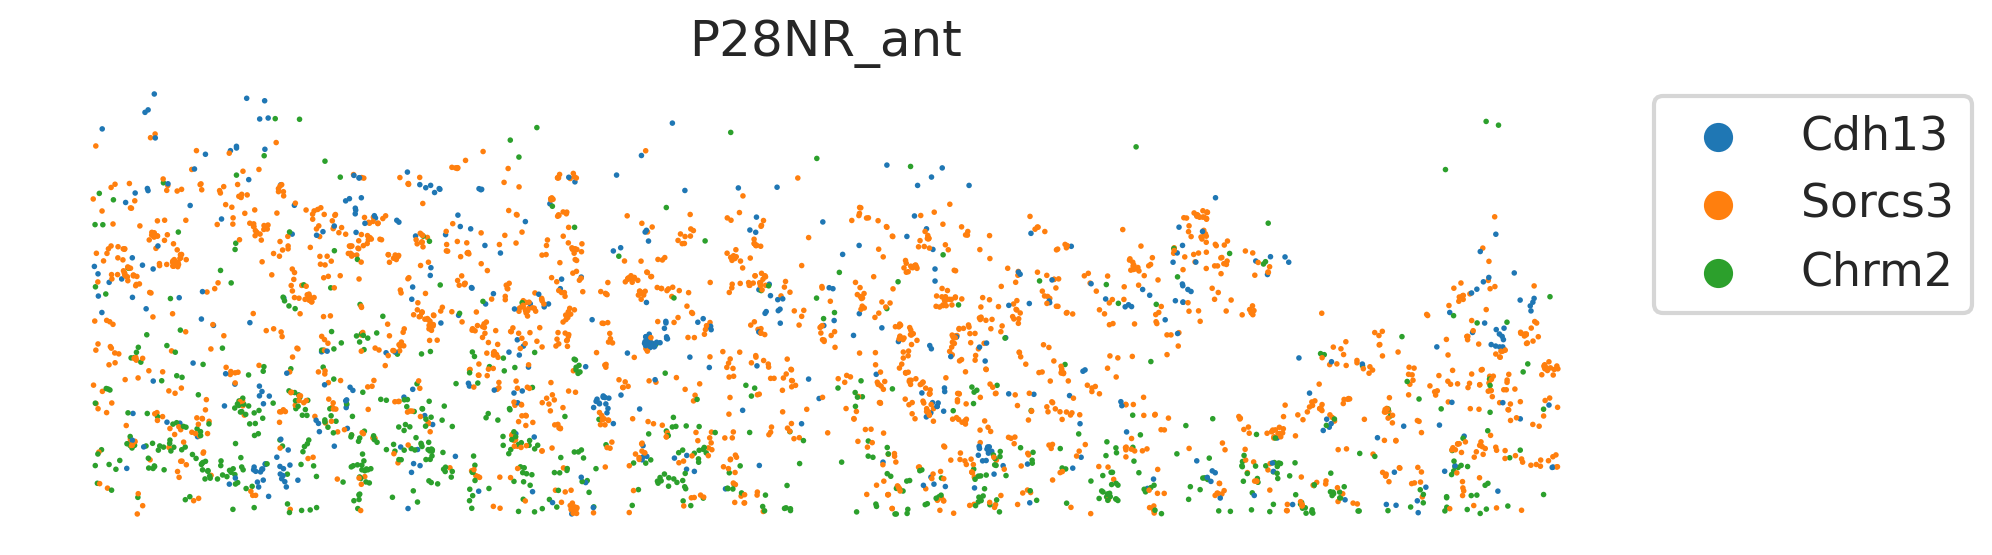

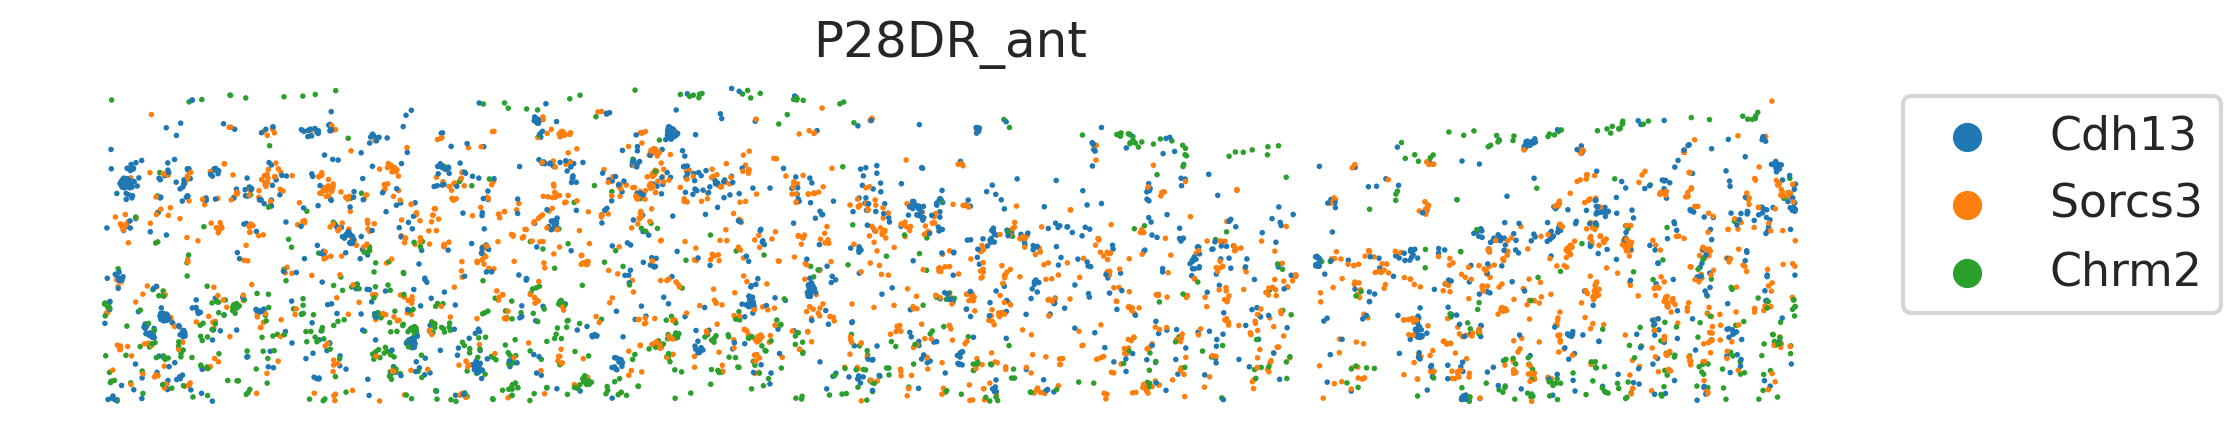

In [7]:
query_genes = ['Cdh13', 'Sorcs3', 'Chrm2']

for name, df in dfs.items():
    abc = df[df['gene'].isin(query_genes)]
    
    fig, ax = plt.subplots(1,1,figsize=(12,3))
    sns.scatterplot(data=abc.sample(frac=1, replace=False), 
                    x='width', y='depth', hue='gene', hue_order=query_genes, 
                    s=4, edgecolor='none', ax=ax, )
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_title(name)
    ax.legend(bbox_to_anchor=(1,1))
    ax.invert_yaxis()

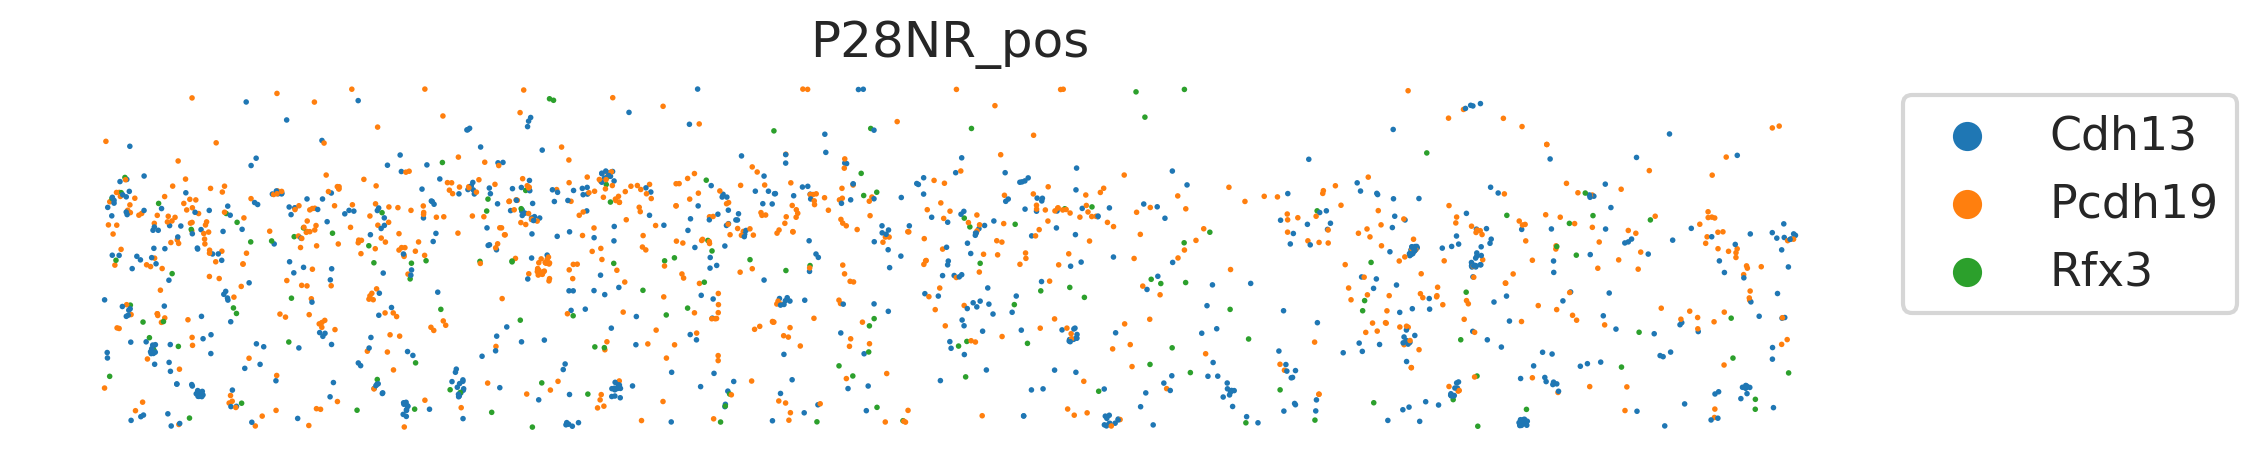

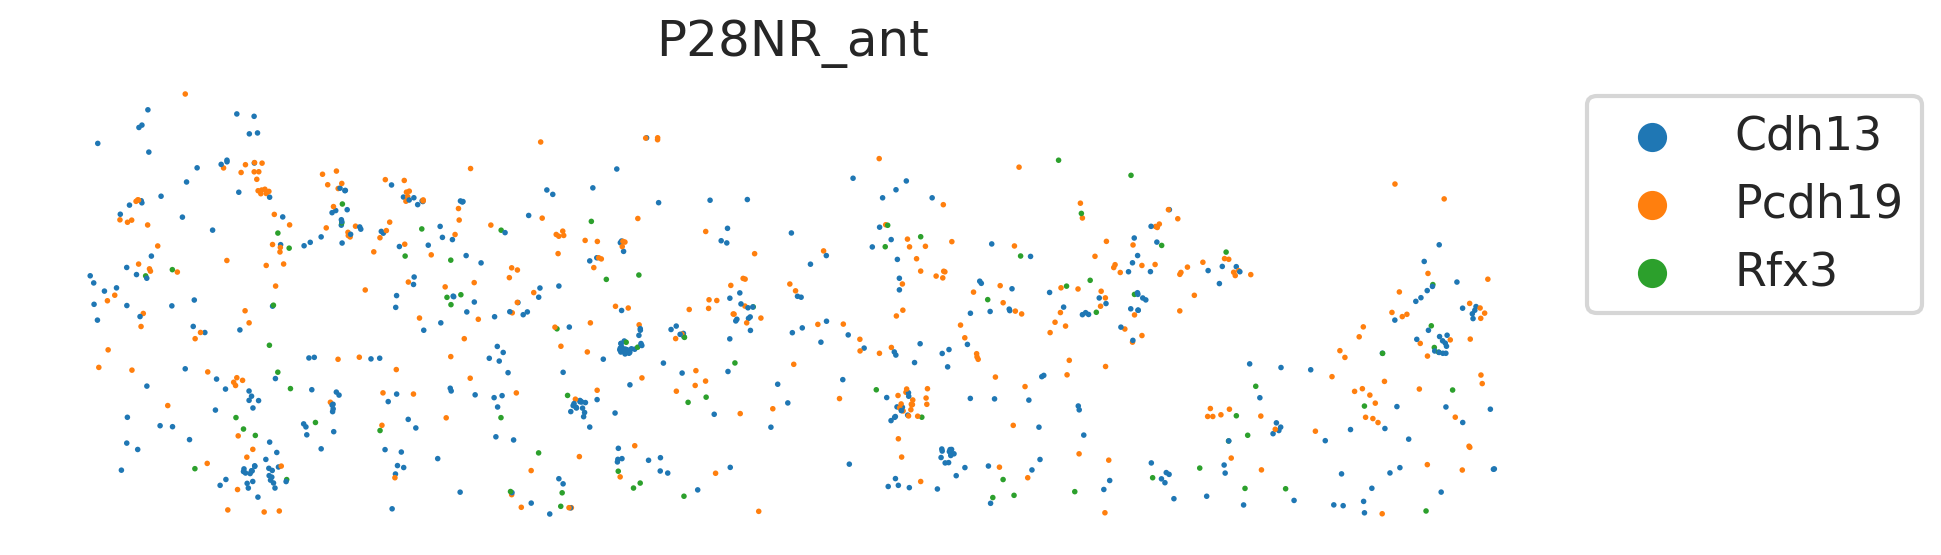

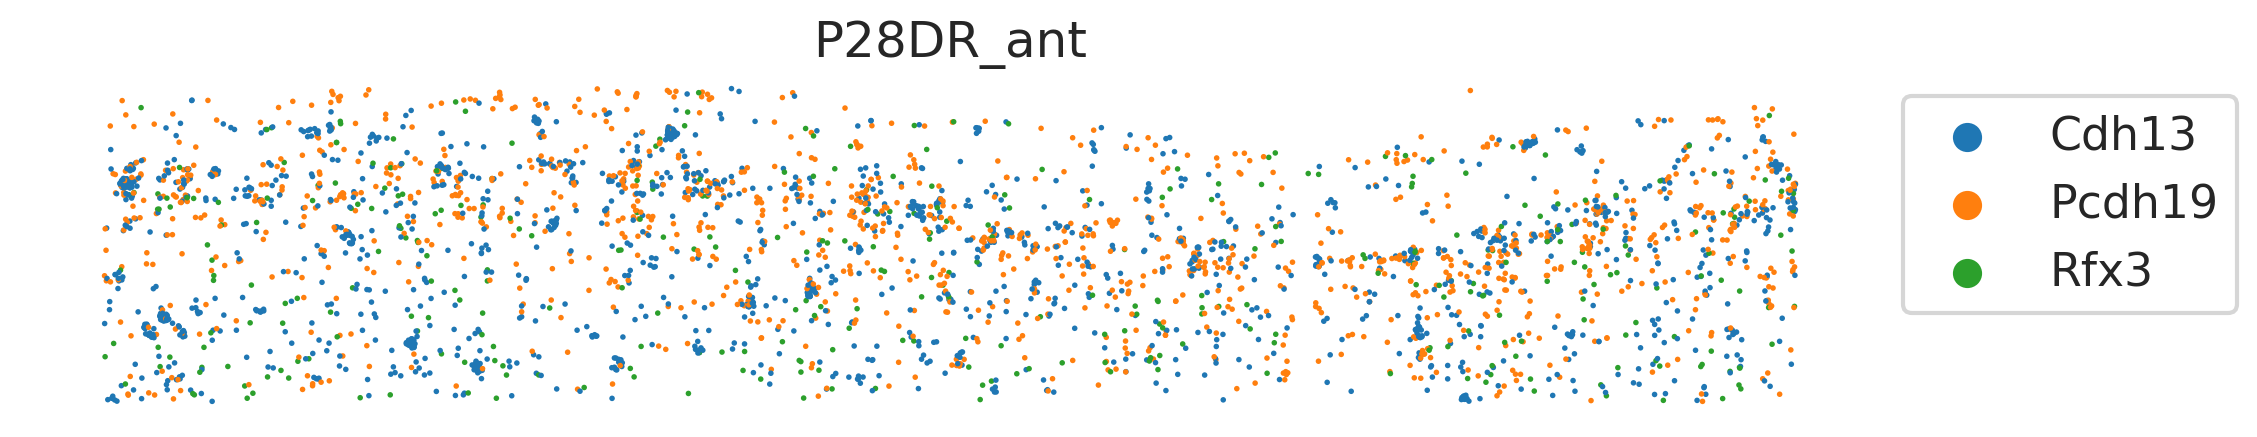

In [8]:
query_genes = ['Cdh13', 'Pcdh19', 'Rfx3']

for name, df in dfs.items():
    abc = df[df['gene'].isin(query_genes)]
    
    fig, ax = plt.subplots(1,1,figsize=(12,3))
    sns.scatterplot(data=abc.sample(frac=1, replace=False), 
                    x='width', y='depth', hue='gene', hue_order=query_genes, 
                    s=4, edgecolor='none', ax=ax, )
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_title(name)
    ax.legend(bbox_to_anchor=(1,1))
    ax.invert_yaxis()

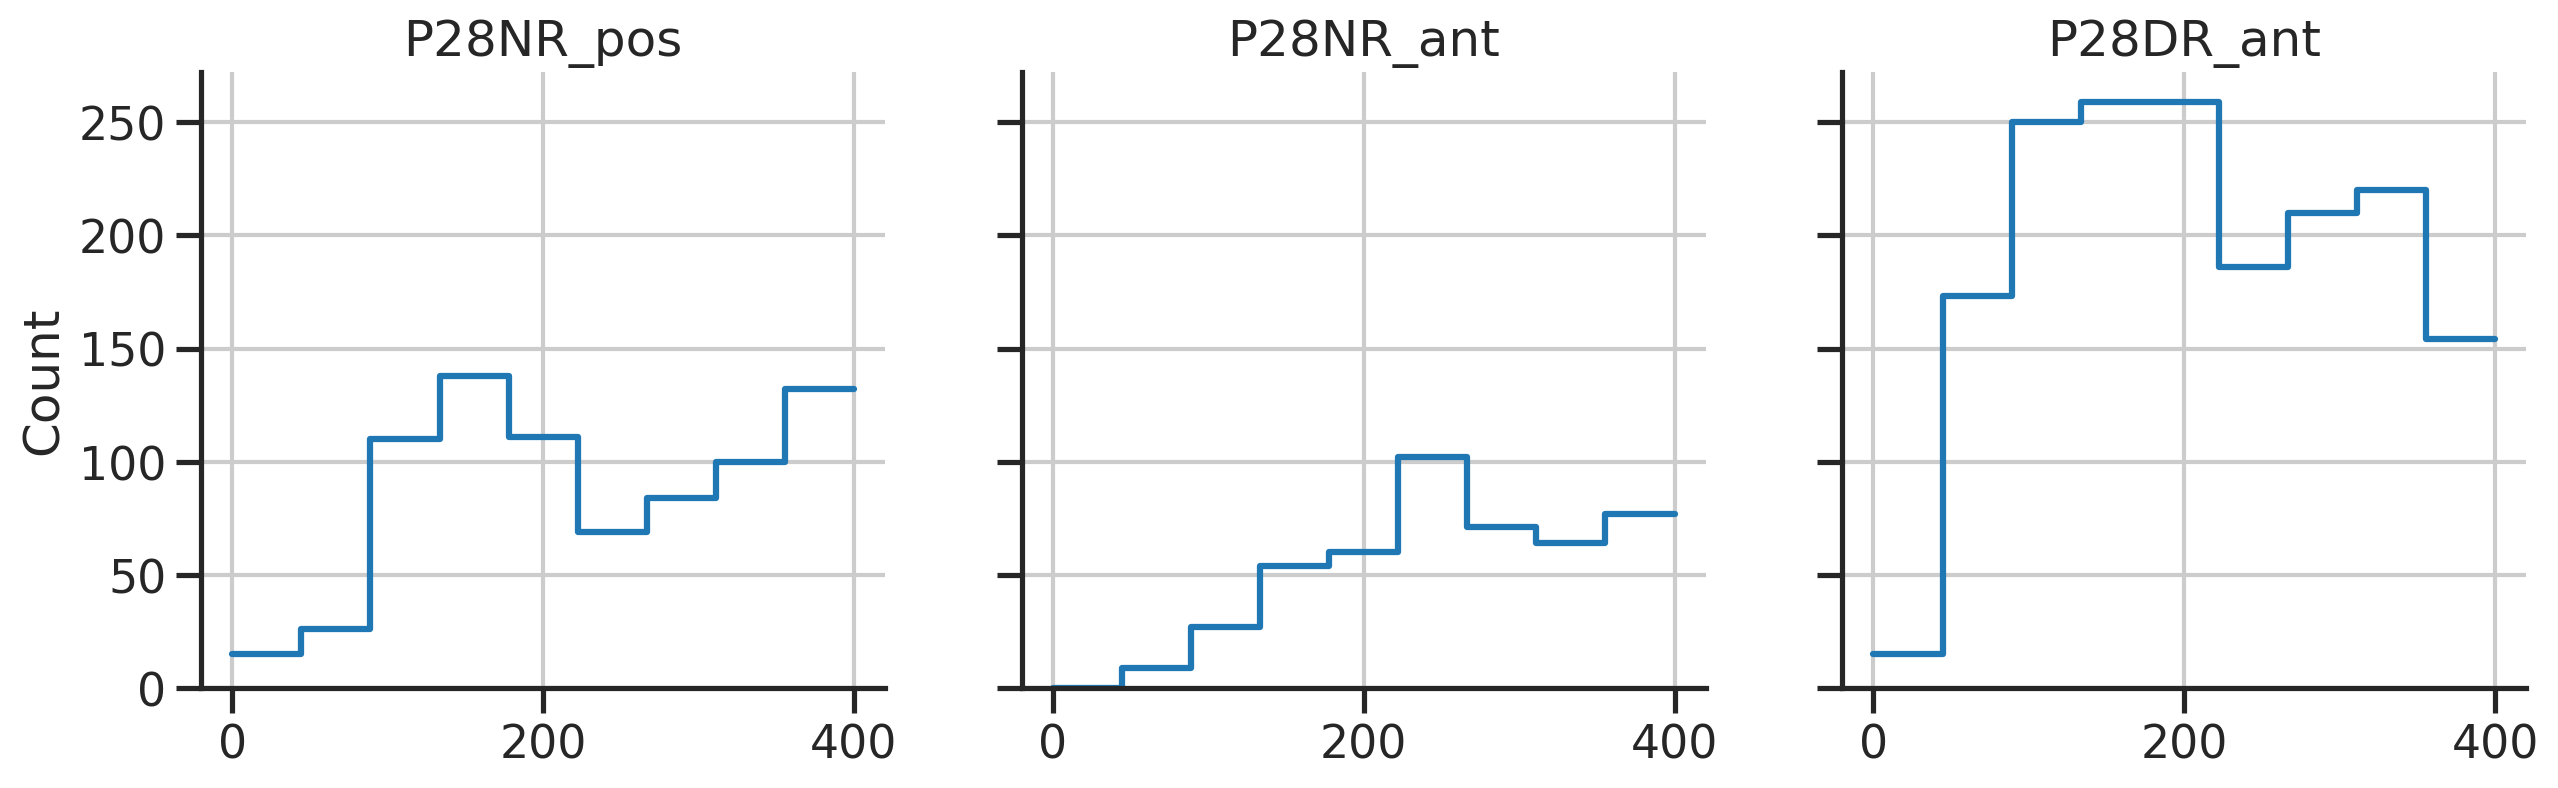

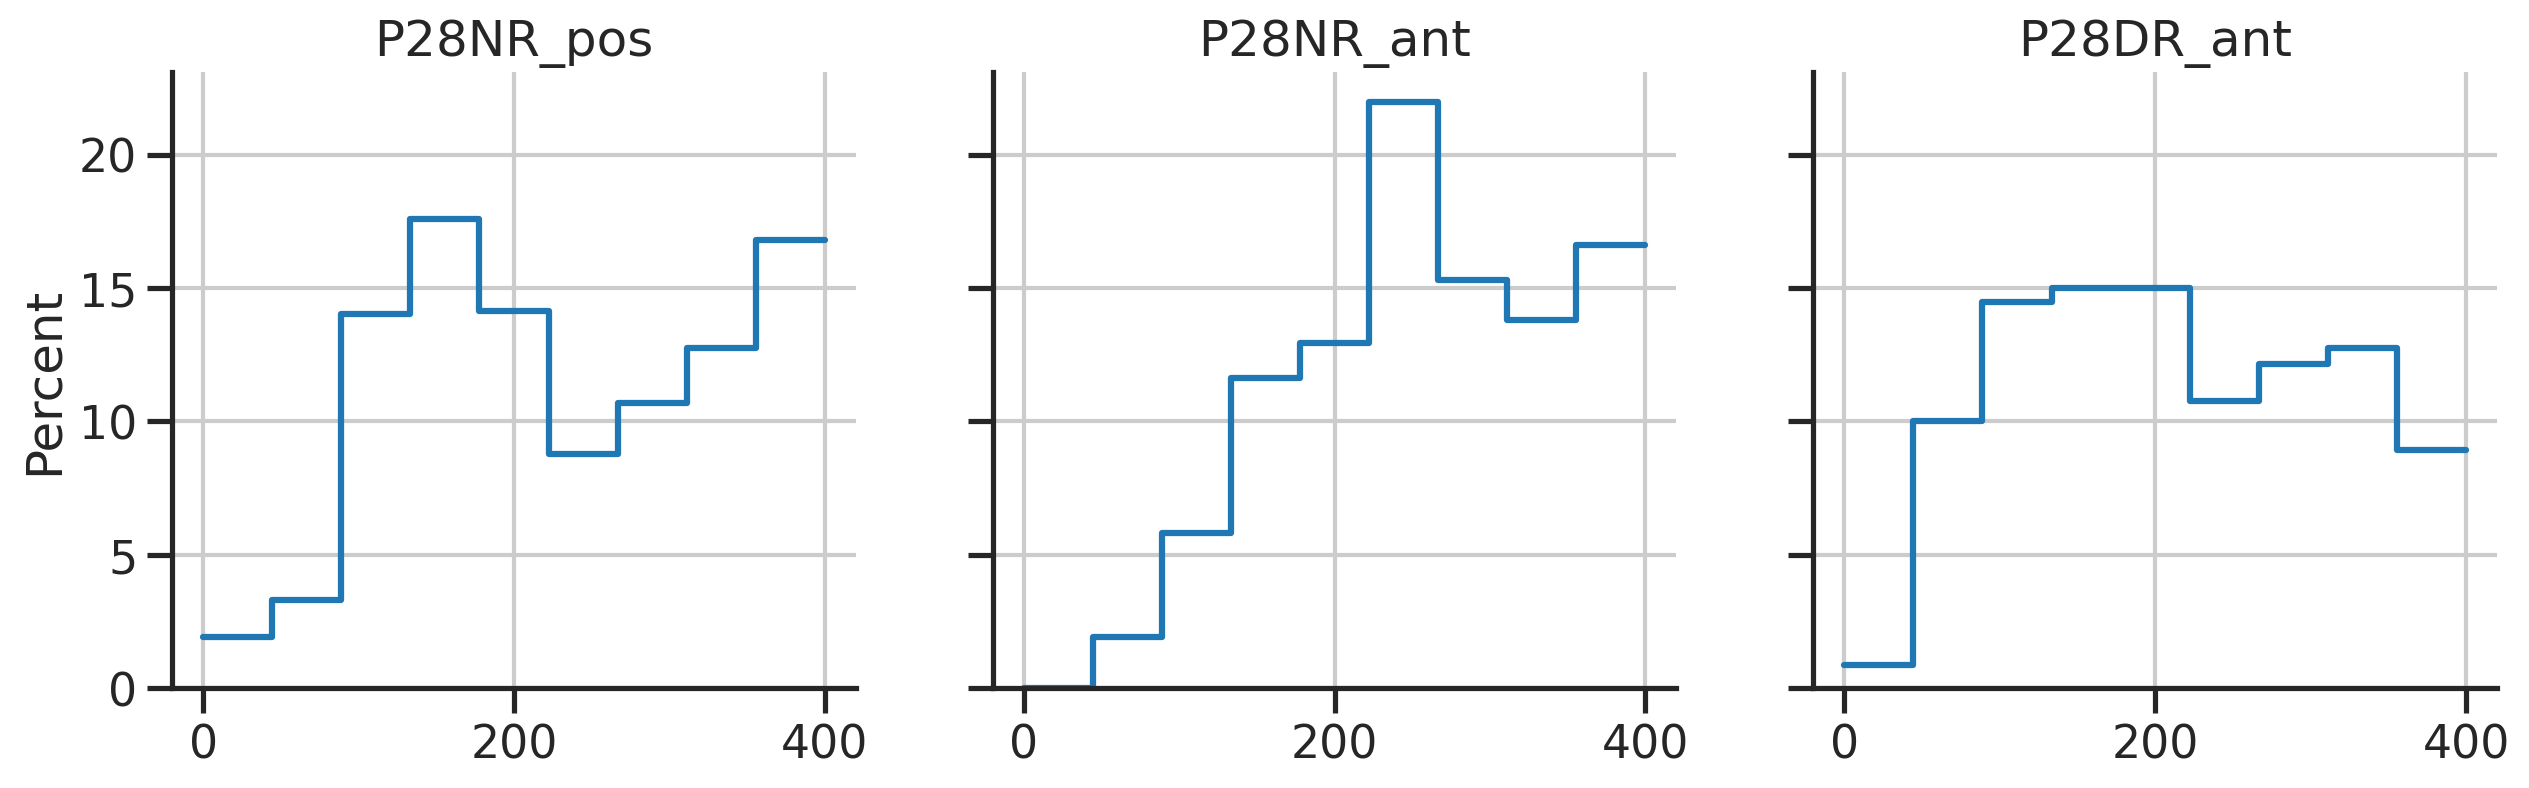

In [9]:
_bins = np.linspace(0,400,10)
stat = 'count'
fig, axs = plt.subplots(1, 3, figsize=(3*5,1*4), sharex=True, sharey=True)
for i, (name, df) in enumerate(dfs.items()):
    ax = axs[i]
    abc = df[df['gene'].isin(query_genes)]

    d = abc[abc['gene']=='Cdh13']['depth']
    sns.histplot(d.values, bins=_bins, stat=stat, element='step', fill=False, ax=ax)
    d = abc[abc['gene']=='Sorcs3']['depth']
    sns.histplot(d.values, bins=_bins, stat=stat, element='step', fill=False, ax=ax)
    d = abc[abc['gene']=='Chrm2']['depth']
    sns.histplot(d.values, bins=_bins, stat=stat, element='step', fill=False, ax=ax)
    sns.despine(ax=ax)
    ax.set_title(name)
    
stat = 'percent'
fig, axs = plt.subplots(1, 3, figsize=(3*5,1*4), sharex=True, sharey=True)
for i, (name, df) in enumerate(dfs.items()):
    ax = axs[i]
    abc = df[df['gene'].isin(query_genes)]

    d = abc[abc['gene']=='Cdh13']['depth']
    sns.histplot(d.values, bins=_bins, stat=stat, element='step', fill=False, ax=ax)
    d = abc[abc['gene']=='Sorcs3']['depth']
    sns.histplot(d.values, bins=_bins, stat=stat, element='step', fill=False, ax=ax)
    d = abc[abc['gene']=='Chrm2']['depth']
    sns.histplot(d.values, bins=_bins, stat=stat, element='step', fill=False, ax=ax)
    sns.despine(ax=ax)
    ax.set_title(name)

In [10]:
sns.color_palette('tab20c')

[(0.19215686274509805, 0.5098039215686274, 0.7411764705882353),
 (0.4196078431372549, 0.6823529411764706, 0.8392156862745098),
 (0.6196078431372549, 0.792156862745098, 0.8823529411764706),
 (0.7764705882352941, 0.8588235294117647, 0.9372549019607843),
 (0.9019607843137255, 0.3333333333333333, 0.050980392156862744),
 (0.9921568627450981, 0.5529411764705883, 0.23529411764705882),
 (0.9921568627450981, 0.6823529411764706, 0.4196078431372549),
 (0.9921568627450981, 0.8156862745098039, 0.6352941176470588),
 (0.19215686274509805, 0.6392156862745098, 0.32941176470588235),
 (0.4549019607843137, 0.7686274509803922, 0.4627450980392157),
 (0.6313725490196078, 0.8509803921568627, 0.6078431372549019),
 (0.7803921568627451, 0.9137254901960784, 0.7529411764705882),
 (0.4588235294117647, 0.4196078431372549, 0.6941176470588235),
 (0.6196078431372549, 0.6039215686274509, 0.7843137254901961),
 (0.7372549019607844, 0.7411764705882353, 0.8627450980392157),
 (0.8549019607843137, 0.8549019607843137, 0.9215686274509803),
 (0.38823529411764707, 0.38823529411764707, 0.38823529411764707),
 (0.5882352941176471, 0.5882352941176471, 0.5882352941176471),
 (0.7411764705882353, 0.7411764705882353, 0.7411764705882353),
 (0.8509803921568627, 0.8509803921568627, 0.8509803921568627)]

In [11]:
linestyles = {
    'P28NR_ant': '-',
    'P28NR_pos': '-',
    'P28DR_ant': '--',
}

colors = {
    'P28NR_pos': sns.color_palette('tab20c')[5],
    'P28NR_ant': sns.color_palette('tab20c')[6],
    
    'P28DR_ant': 'k',
}

bins = np.linspace(0,400,15)
midpoints = np.mean([bins[:-1], bins[1:]], axis=0)

In [12]:
# size normed counts
df_dbins = {}
for name in names:
    df = dfs[name]
    df['depth_bin'] = pd.cut(df['depth'].values, bins=bins)
    df_dbin = df.groupby(['depth_bin', 'gene']).size().unstack()
    df_dbins[name] = df_dbin/area_factors[name]

In [13]:
# norm each gene
gene_mean_refs = pd.concat([
    df_dbins['P28NR_pos'].mean(), 
    df_dbins['P28NR_ant'].mean()], 
    axis=1).mean(axis=1)
gene_mean_refs

gene
6530403H02Rik     12.297619
Abcg1            228.809524
Adamts17          23.857143
Adamts2           57.369048
Adipor2           63.571429
                    ...    
Zfp618            31.440476
Zfp804a           53.095238
Zfp804b           15.785714
Zfpm2             54.250000
Zmat4             66.678571
Length: 550, dtype: float64

In [14]:
df_dbin_fcs = {}
for name in names:
    df_dbin = df_dbins[name]
    df_dbin_fc = df_dbin/gene_mean_refs
    df_dbin_fcs[name] = df_dbin_fc

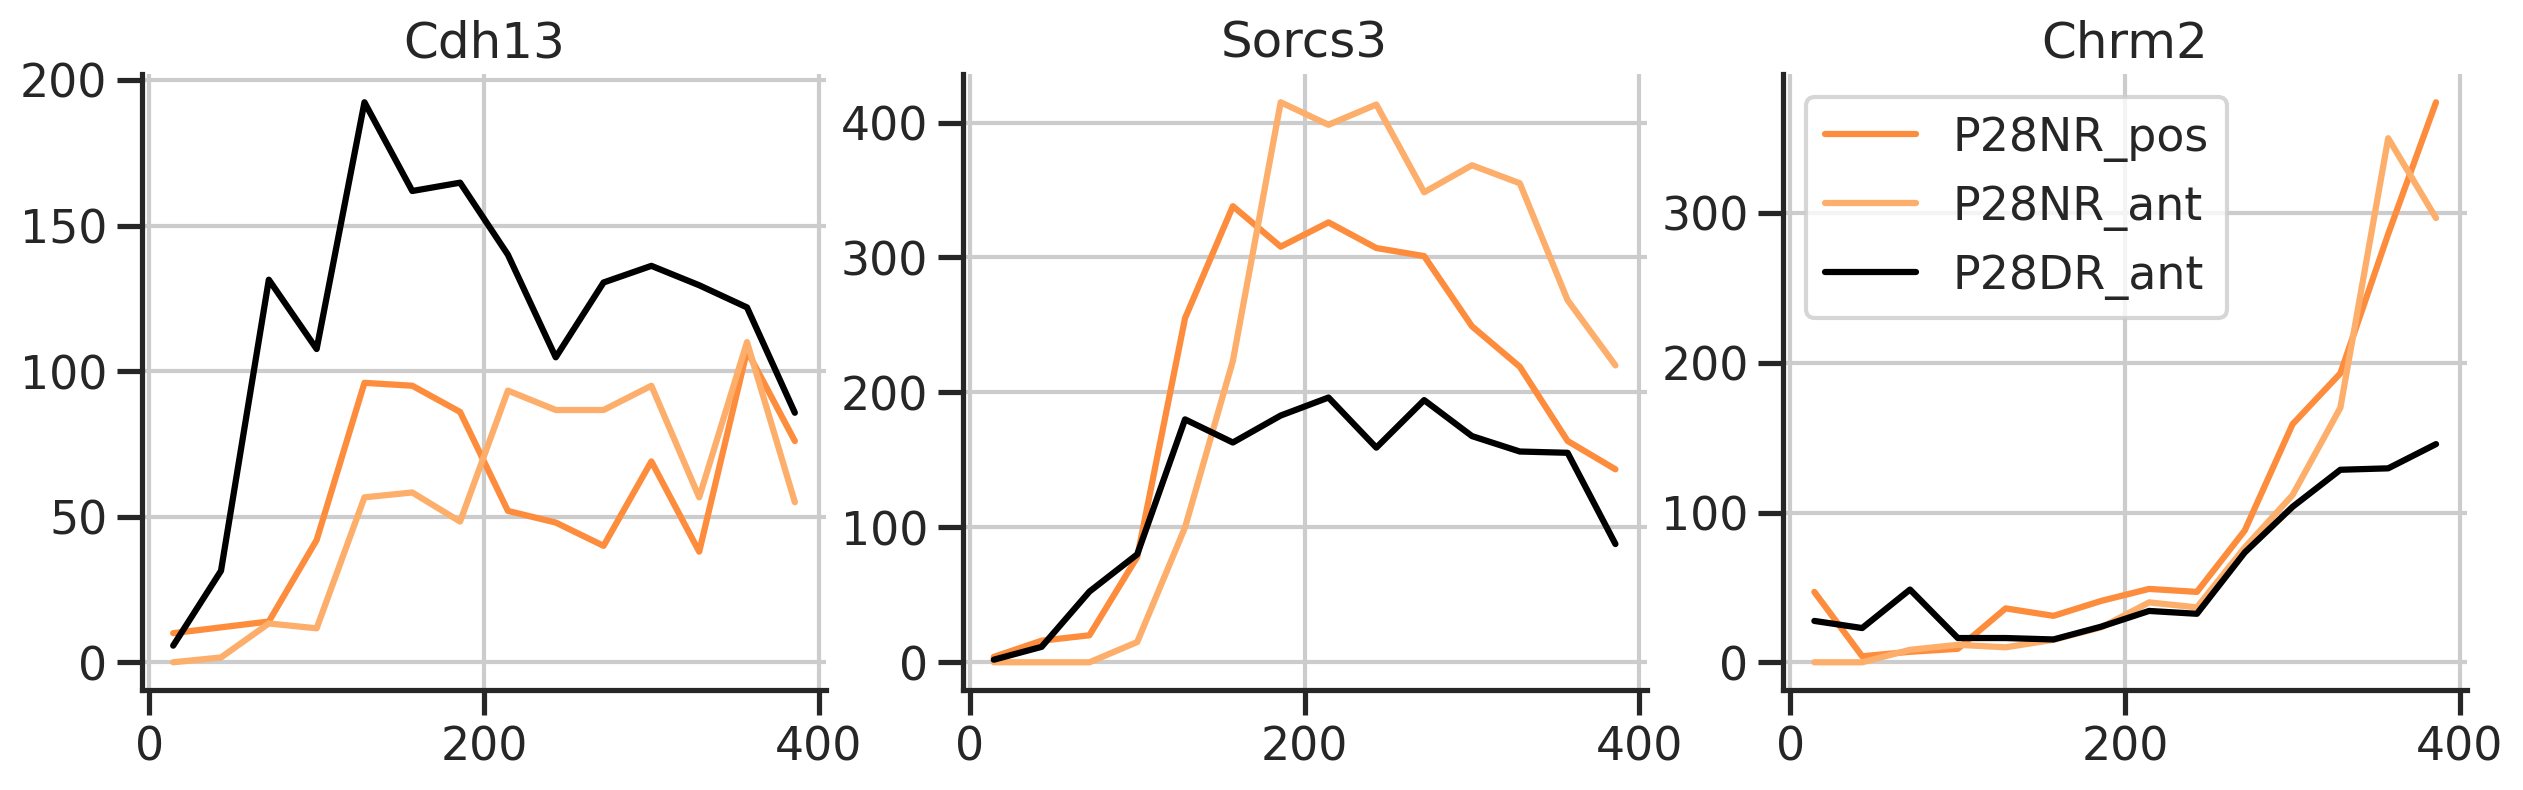

In [15]:
query_genes = ['Cdh13', 'Sorcs3', 'Chrm2']
fig, axs = plt.subplots(1, 3, figsize=(3*5,1*4), sharex=True, sharey=False)
for j, gene in enumerate(query_genes):
    ax = axs[j]
    ax.set_title(gene)
    for i, name in enumerate(names):
        color = colors[name]
        hist_norm  = df_dbins[name][gene]
        ax.plot(midpoints, hist_norm, 
                color=color, label=name)
        sns.despine(ax=ax)

ax.legend()
plt.show()

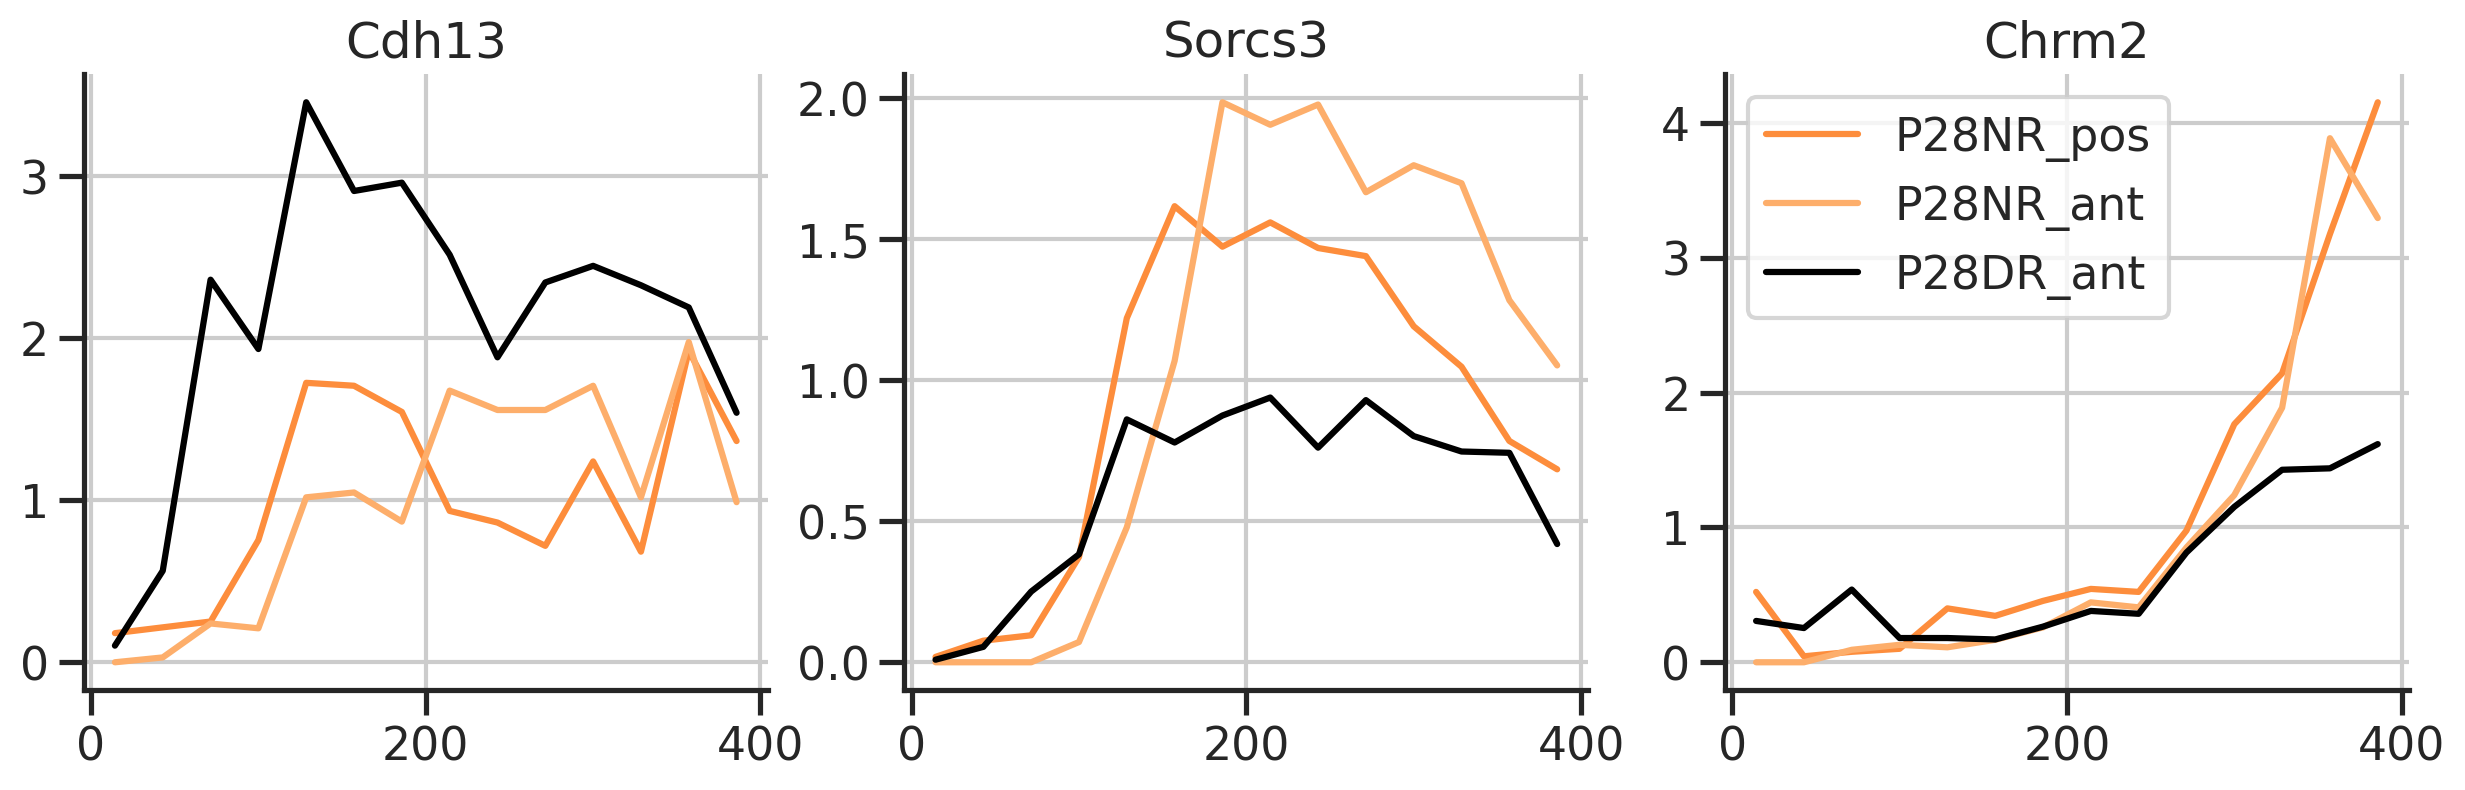

In [16]:
query_genes = ['Cdh13', 'Sorcs3', 'Chrm2']
fig, axs = plt.subplots(1, 3, figsize=(3*5,1*4), sharex=True, sharey=False)
for j, gene in enumerate(query_genes):
    ax = axs[j]
    ax.set_title(gene)
    for i, name in enumerate(names):
        color = colors[name]
        hist_norm_fc  = df_dbin_fcs[name][gene]
        ax.plot(midpoints, hist_norm_fc, 
                color=color, label=name)
        sns.despine(ax=ax)

ax.legend()
plt.show()

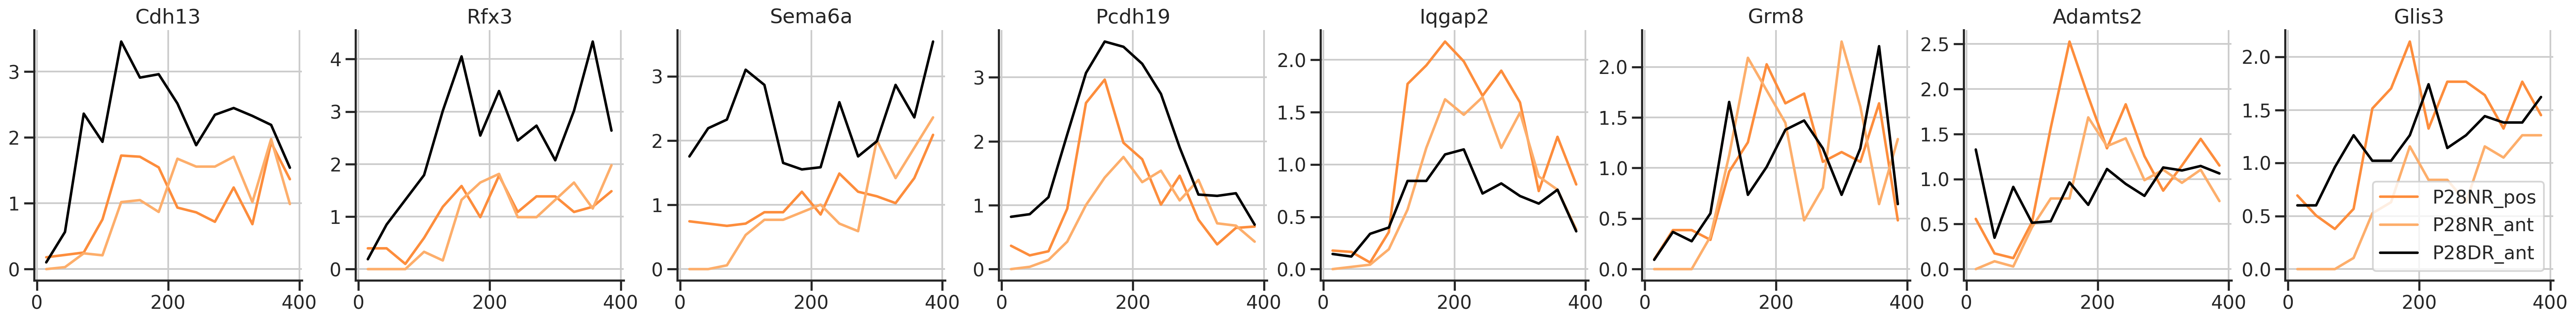

In [17]:
query_genes = ['Cdh13', 'Rfx3', 'Sema6a', 'Pcdh19', 'Iqgap2', 'Grm8', 'Adamts2', 'Glis3']
n = len(query_genes)
fig, axs = plt.subplots(1, n, figsize=(n*5,1*4), sharex=True, sharey=False)
for j, gene in enumerate(query_genes):
    ax = axs[j]
    ax.set_title(gene)
    for i, name in enumerate(names):
        color = colors[name]
        hist_norm_fc  = df_dbin_fcs[name][gene]
        ax.plot(midpoints, hist_norm_fc, 
                color=color, label=name)
        sns.despine(ax=ax)

ax.legend()
plt.show()

In [18]:
# try - Genes NR vs DR (MERFISH vs scRNA-seq)
# try - MERFISH cell typings on a triangle

# ABC genes

In [19]:
f = '/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/results/MERFISH_gene_panel_Version1_March9.csv'
df1 = pd.read_csv(f)
f = '/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/results/gene_ptime_P28_L23_Mar27.tsv'
df2 = pd.read_csv(f).sort_values('gene_ptime')
df = pd.merge(df1, df2, left_on='gene_name_data', right_on='gene').sort_values('gene_ptime')
genes_abco = df['gene_name_vizgen'].values
genes_abco.shape

(170,)

In [20]:
agenes = df[df['P17on_x']=='A']['gene_name_vizgen'].values
bgenes = df[df['P17on_x']=='B']['gene_name_vizgen'].values
cgenes = df[df['P17on_x']=='C']['gene_name_vizgen'].values
len(agenes), agenes, len(bgenes), bgenes, len(cgenes), cgenes

(64,
 array(['Met', '6530403H02Rik', 'Rhbdl3', 'Adamts2', 'Cdh13', 'Col23a1',
        'Vwc2l', 'Syt10', 'Kcnn3', 'Arhgef28', 'Pcdh19', 'Pakap', 'Ikzf2',
        'Nckap5', 'Dpyd', 'Gpc5', 'Slc6a7', 'Igsf11', 'Glis3', 'Ttc28',
        'Tenm1', 'Syt17', 'Robo1', 'Sema6a', 'Otof', 'Eda', 'Plxna1',
        'Tox3', 'Itga8', 'Kcnk13', 'Wnt4', 'Sdk2', 'Pdzrn4', 'Plxnd1',
        'Ryr3', 'Necab1', 'Camk2d', 'Iqgap2', 'Pdgfc', 'Gabrg3', 'Dscaml1',
        'Reln', 'Npas3', 'Cntn5', 'Rfx3', 'Grm1', 'Kirrel3', 'Nfib',
        'Fkbp5', 'Zfp608', 'Meis2', 'Mdga1', 'Tiam1', 'Grb14', 'Nkain3',
        'Epha6', 'Cacna1h', 'Pde1a', 'Nr3c2', 'Matn2', 'Tmem150c',
        'Adamts17', 'Ldb2', 'Egfem1'], dtype=object),
 35,
 array(['Grm8', 'Galnt17', 'Epha3', 'Rgs8', 'Sox5', 'Zfp804b', 'Tmeff1',
        'Fstl5', 'Cdh4', 'Kcnip3', 'Myh9', 'Sh3pxd2b', 'Klhl1', 'Trpc6',
        'Sema4a', 'Tafa1', 'Sertm1', 'Nrp1', 'Col26a1', 'Mas1', 'Igfn1',
        'Npas4', 'Scg3', 'Nptx2', 'Bdnf', 'Phf21b', 'Nell1', 'Baz1a',
 

In [21]:
iegs = [
    'Fos',
    'Fosl2',
    'Nr4a1',
    'Egr1',
    'Nr4a2',
    'Nr4a3',
    'Crem',
    'Egr4',
    'Fosb',
    'Egr2',
    'Per1',
    'Junb',
    'Cebpb',
    'Klf4',
    'Atf3',
    'Klf2',
    'Maff',
    'Klf10',
    'Jund',
    'Mafk',
    'Srf',
    'Arc',
]

len(iegs)

22

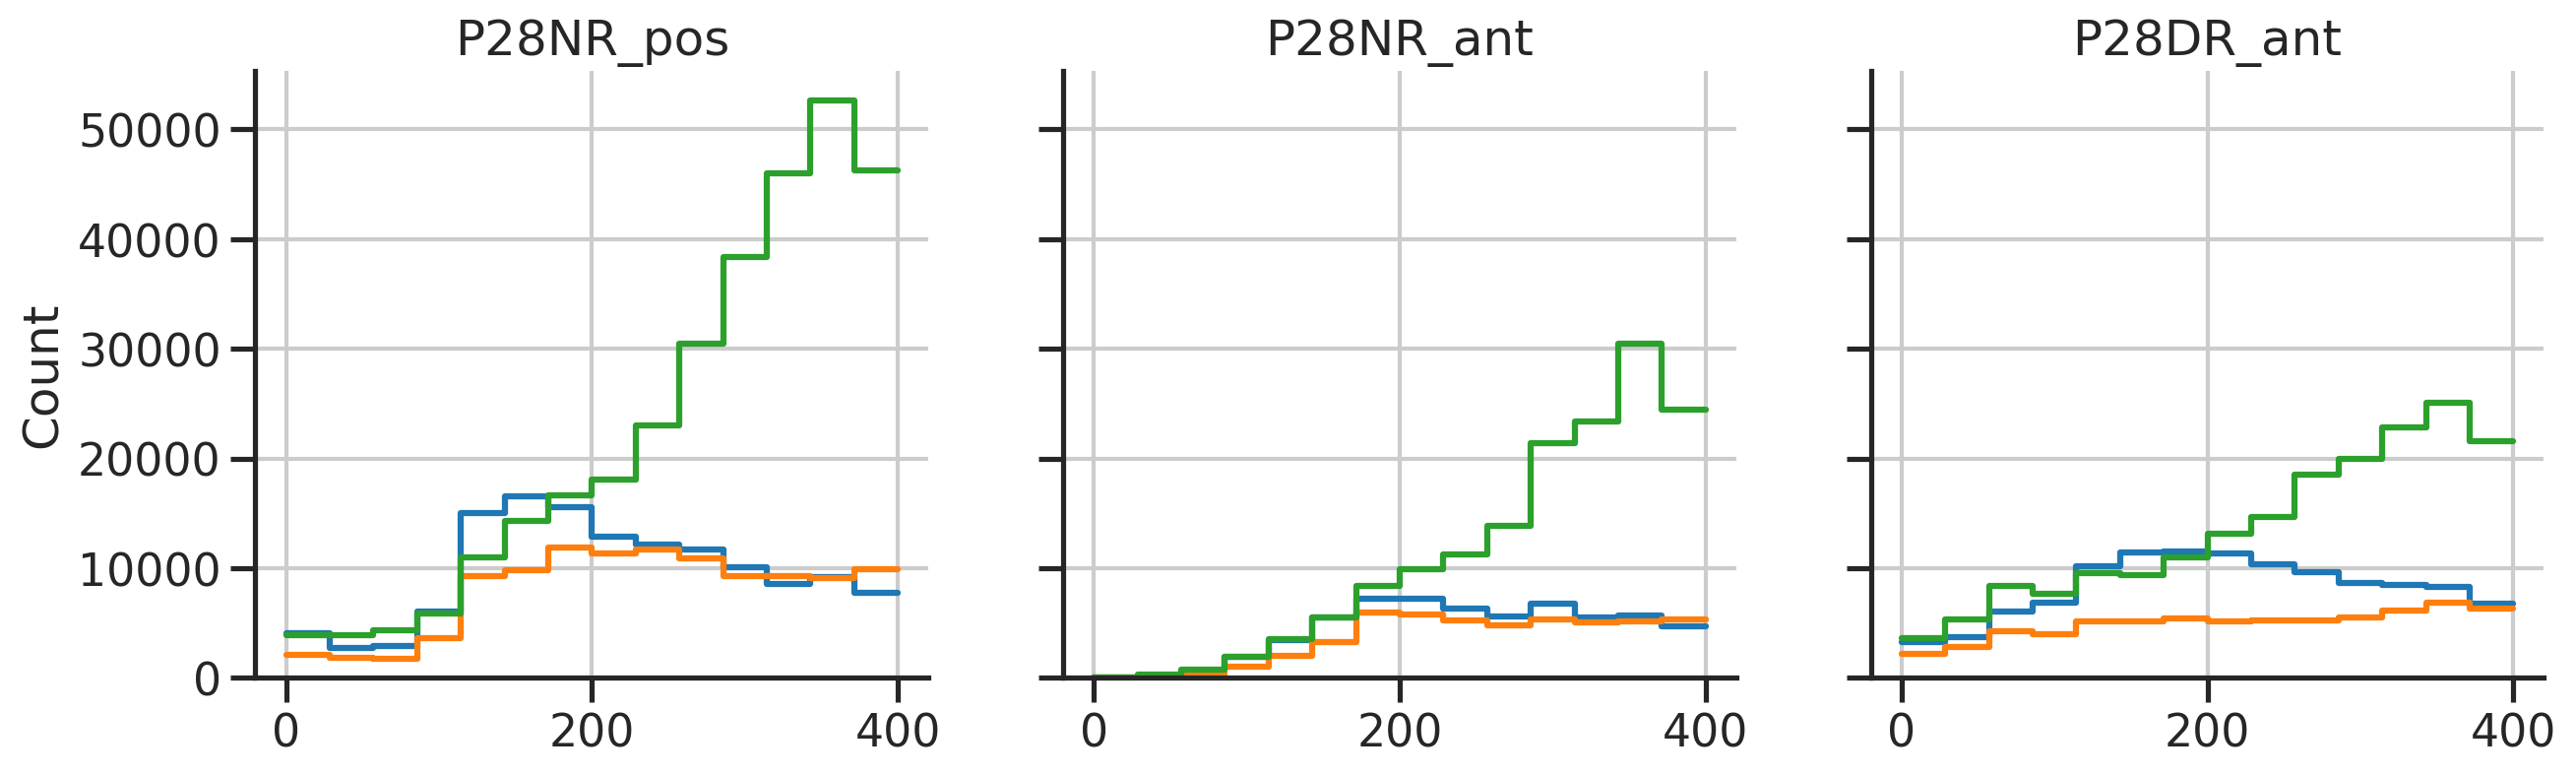

In [22]:
stat = 'count'
fig, axs = plt.subplots(1, 3, figsize=(3*5,1*4), sharex=True, sharey=True)
for i, (name, df) in enumerate(dfs.items()):
    ax = axs[i]
    d = df[df['gene'].isin(agenes)]['depth']
    sns.histplot(d.values, bins=bins, stat=stat, element='step', fill=False, ax=ax)
    d = df[df['gene'].isin(bgenes)]['depth']
    sns.histplot(d.values, bins=bins, stat=stat, element='step', fill=False, ax=ax)
    d = df[df['gene'].isin(cgenes)]['depth']
    sns.histplot(d.values, bins=bins, stat=stat, element='step', fill=False, ax=ax)
    sns.despine(ax=ax)
    ax.set_title(name)

In [23]:
from scipy.stats import gmean
def geometric_mean(vals, clip=1e-2):
    """
    vals needs to be positive...
    """
    return np.exp(np.nanmean(np.log(np.clip(vals, clip, None))))

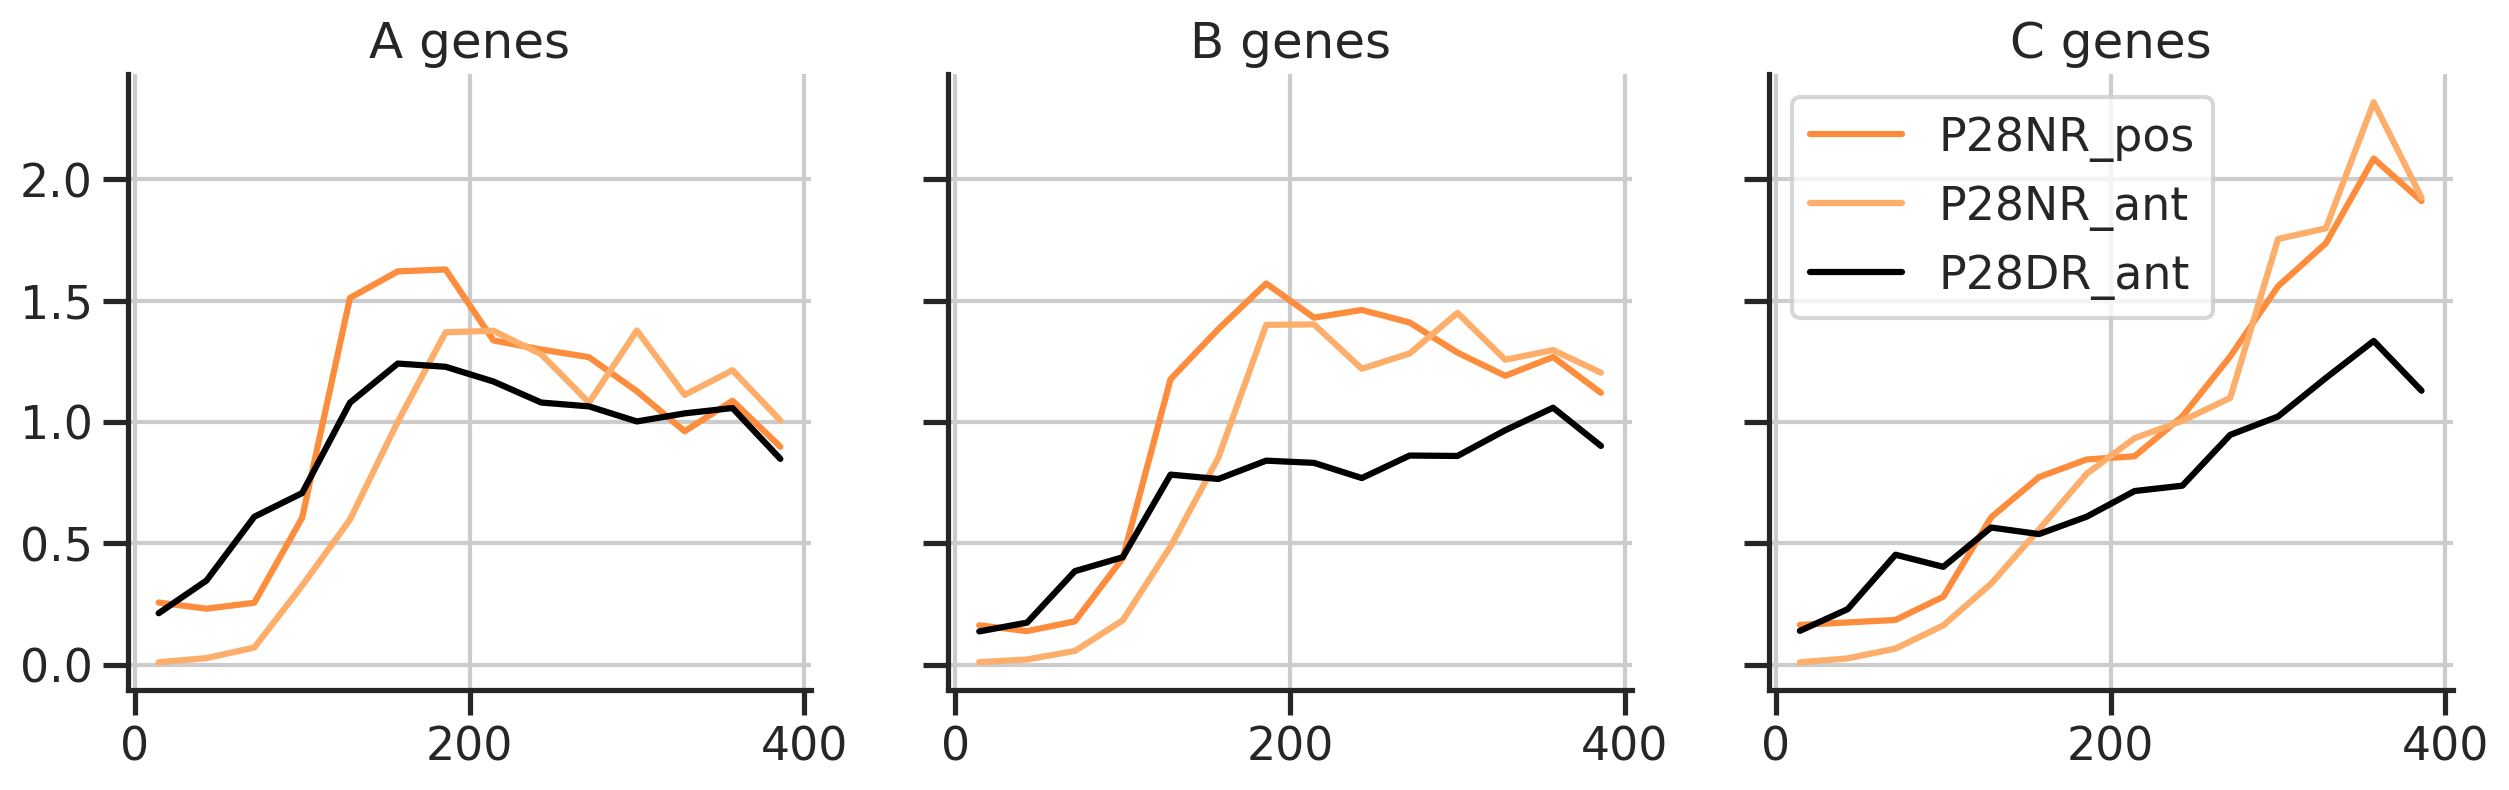

In [24]:
midpoints = np.mean([bins[:-1], bins[1:]], axis=0)
query_genesets = [agenes, bgenes, cgenes]# iegs]
titles = ['A genes', 'B genes', 'C genes']#, 'IEGs']

fig, axs = plt.subplots(1, 3, figsize=(3*5,1*4), sharex=True, sharey=True)
for j, geneset in enumerate(query_genesets):
    ax = axs[j]
    ax.set_title(titles[j])
    for i, (name) in enumerate(names):
        
        color = colors[name]
        hist_norm_fc  = (df_dbin_fcs[name][geneset]).apply(geometric_mean, axis=1) # mean(axis=1) # geometric mean
        ax.plot(midpoints, hist_norm_fc, 
                color=color, label=name)
        sns.despine(ax=ax)

ax.legend()


# 20 EASI-FISH genes